[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/EOPF-Sample-Service/eopf-sample-notebooks/v0.1?filepath=notebooks/EOPF_Tutorials/Sentinel-2_L1C_MSI_product_format_prototype.ipynb)


---
title: Sentinel-2 L1C MSI Product Format Prototype
subtitle: Explore how to open, visualise and plot Sentinel-2 L1C MSI EOPF ZARR format
authors:
  - name: Suriyah Dhinakaran
    orcid: 0009-0007-0355-7372
    github: suriyahgit
    affiliations:
      - id: Eurac Research
        institution: Eurac Research
        ror: 01xt1w755
  - name: Michele Claus
    orcid: 0000-0003-3680-381X
    github: clausmichele
    affiliations:
      - id: Eurac Research
        institution: Eurac Research
        ror: 01xt1w755
date: 2025-03-19
thumbnail: https://raw.githubusercontent.com/EOPF-Sample-Service/eopf-sample-notebooks/refs/heads/main/notebooks/static/ESA_logo_2020_Deep.png
keywords : earth and related environmental sciences
releaseDate: 2025-03-19
datePublished: 2025-03-19
dateModified: 2025-03-19
---

```{image} ../static/ESA_EOPF_logo_2025_COLOR_ESA_blue_reduced.png
:alt: ESA EOPF Zarr Logo
:width: 250px
:align: center
```

## Table of Contents
1. [Introduction](#Introduction)  
2. [Import modules](#Import-modules)  
3. [Open the product](#Open-the-product)  
4. [Overview of the product content](#Overview-of-the-product-content)  
5. [Plot a RGB image](#Plot-a-RGB-image)  
6. [Explore product geolocation](#Explore-product-geolocation)  
   A. [Interactive map](#Interactive-map)  
   B. [Non-interactive map](#Non-interactive-map)  
   C. [Plot georeferenced data](#Plot-georeferenced-data)
7. [Compute radiances](#Compute-radiances)
8. [Visualise](#Visualise)


## Introduction

This notebook demonstrates how to open, explore, and visualize Sentinel-2 Level 1C MSI products stored in EOPF ZARR format, including plotting RGB images and analyzing geolocation data.

## Import modules

Dependencies

- eopf
- xarray
- matplotlib
- cartopy
- numpy
- geopandas
- graphviz

In [1]:
from eopf.product.eo_variable import EOVariable
import cartopy.crs as ccrs  # For static plotting
import cartopy.feature as cf
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import xarray as xr

## Open the product


In [2]:
remote_product_path = "https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S2B_MSIL1C_20250113T103309_N0511_R108_T32TLQ_20250113T122458.zarr"
dt = xr.open_datatree(remote_product_path, engine="zarr", chunks={})

## Overview of the product content

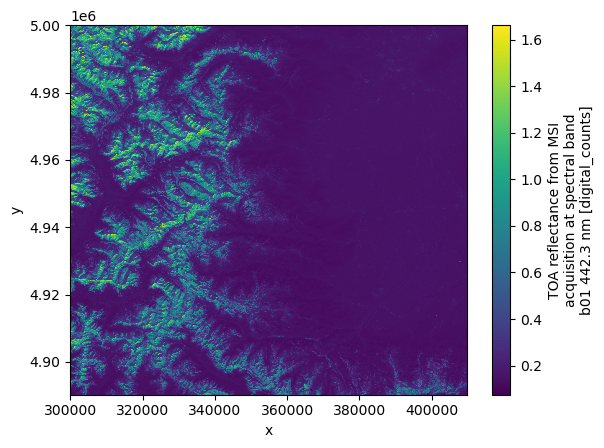

In [3]:
dt["measurements/reflectance/r60m"]["b01"].plot()

In [4]:
dt["measurements/reflectance/r60m"]["b01"].encoding["add_offset"]

-0.1

In [5]:
min, max, mean = (
    dt["measurements/reflectance/r60m"]["b01"].data.max(),
    dt["measurements/reflectance/r60m"]["b01"].data.min(),
    dt["measurements/reflectance/r60m"]["b01"].data.mean(),
)
min.compute(), max.compute(), mean.compute()

(1.6631, 0.0746, 0.27504428200304576)

In [6]:
r = dt["measurements/reflectance/r10m"]["b04"]
g = dt["measurements/reflectance/r10m"]["b03"]
b = dt["measurements/reflectance/r10m"]["b02"]

xr.Dataset(dict(r=r, g=g, b=b))
# Check indexes

<xarray.Dataset> Size: 3GB
Dimensions:  (x: 10980, y: 10980)
Coordinates:
  * x        (x) int64 88kB 300005 300015 300025 300035 ... 409775 409785 409795
  * y        (y) int64 88kB 5000035 5000025 5000015 ... 4890265 4890255 4890245
Data variables:
    r        (y, x) float64 964MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    g        (y, x) float64 964MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    b        (y, x) float64 964MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>

In [7]:
b02 = dt["measurements/reflectance/r10m"]["b02"]
b02

<xarray.DataArray 'b02' (y: 10980, x: 10980)> Size: 964MB
dask.array<open_dataset-b02, shape=(10980, 10980), dtype=float64, chunksize=(1830, 1830), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) int64 88kB 300005 300015 300025 300035 ... 409775 409785 409795
  * y        (y) int64 88kB 5000035 5000025 5000015 ... 4890265 4890255 4890245
Attributes:
    _eopf_attrs:     {'add_offset': -0.1, 'coordinates': ['x', 'y'], 'dimensi...
    dtype:           <u2
    fill_value:      0
    long_name:       TOA reflectance from MSI acquisition at spectral band b0...
    proj:bbox:       [300000.0, 4890240.0, 409800.0, 5000040.0]
    proj:epsg:       32632
    proj:shape:      [10980, 10980]
    proj:transform:  [10.0, 0.0, 300000.0, 0.0, -10.0, 5000040.0, 0.0, 0.0, 1.0]
    proj:wkt2:       PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WG...
    units:           digital_counts
    valid_max:       65535
    valid_min:       1

In [8]:
b02.dtype

dtype('float64')

In [9]:
b02.encoding

{'chunks': (1830, 1830),
 'preferred_chunks': {'y': 1830, 'x': 1830},
 'compressor': Blosc(cname='zstd', clevel=3, shuffle=BITSHUFFLE, blocksize=0),
 'filters': None,
 '_FillValue': 0,
 'scale_factor': 0.0001,
 'add_offset': -0.1,
 'dtype': dtype('uint16')}

## Plot a RGB image


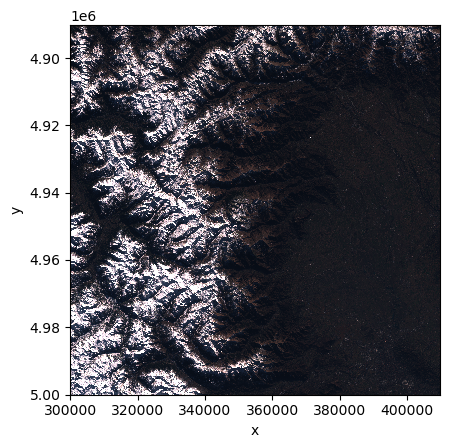

In [10]:
rgb_band_paths = (
    "measurements/reflectance/r10m/b04",
    "measurements/reflectance/r10m/b03",
    "measurements/reflectance/r10m/b02",
)

concat = xr.concat(
    [dt[str(p)] for p in rgb_band_paths],  # type: ignore
    dim="band",
)

ax = concat.plot.imshow()
ax.axes.set_aspect("equal")
plt.gca().invert_yaxis()

## Explore product geolocation

The following snippet shows an interactive map with the tile's footprint
### Interactive map



In [11]:
import geopandas as gpd

# Create a GeoDataFrame from the feature
gdf = gpd.GeoDataFrame.from_features(
    [
        {
            "type": "Feature",
            "geometry": dt.attrs["stac_discovery"][
                "geometry"
            ],  # Use the actual geometry, not the bbox
            "properties": dt.attrs["stac_discovery"][
                "properties"
            ],  # Include all properties
        }
    ],
    crs="EPSG:4326",  # Set the CRS explicitly (adjust EPSG code if needed)
)

Note: CRS is missing from the metadata, it must be set manually



In [12]:
gdf = gdf.set_crs(4326)

In [13]:
gdf.explore()

In [14]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Non-interactive map

The following snippet shows the location of the tile on a global map.




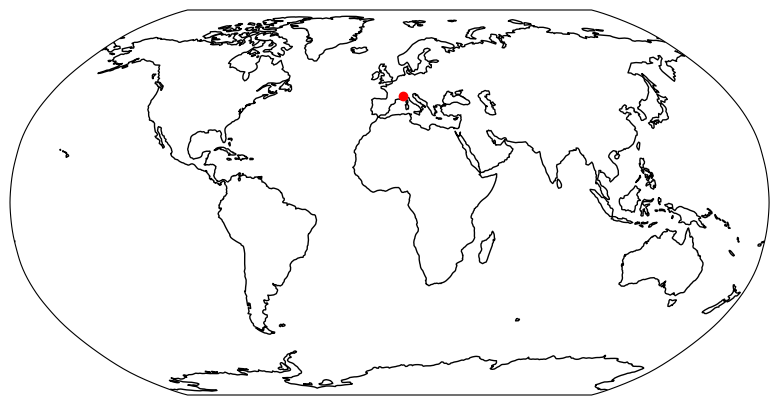

In [15]:
def main():
    # Assume gdf is already defined somewhere before this function
    # Reproject to a projected CRS
    gdf_projected = gdf.to_crs(epsg=3857)  # Change to an appropriate projected CRS
    centroids = gdf_projected.centroid

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

    # Make the map global rather than have it zoom in to the extents of any plotted data
    ax.set_global()

    # ax.stock_img()
    ax.coastlines()

    # Transform back to geographic CRS for plotting
    gdf_centroids_geographic = centroids.to_crs(epsg=4326)

    ax.plot(
        gdf_centroids_geographic.x,
        gdf_centroids_geographic.y,
        "ro",
        transform=ccrs.PlateCarree(),
    )

    plt.show()


if __name__ == "__main__":
    main()

### Plot georeferenced data


In [16]:
# Define constant for plotting
L1C_PROJECTION = ccrs.epsg(32633)
DESIRED_PROJECTION = ccrs.PlateCarree()
FIGSIZE: tuple[int, int] = (12, 8)
RESOLUTION_CARTOPY: str = "110m"
# GEOGRAPHICAL_LIMITS: tuple[int, int, int, int] = (-20, 30, 10, 30)
GEOGRAPHICAL_LIMITS: tuple[int, int, int, int] = (5, 9, 43, 46)

# Speed up plot by sampling data every SKIP_EVERY pixels
SKIP_EVERY: int = 50

# Define plotting arguments for Polygon around the area of interest
POLYGON_THICKNESS: int = 1
POLYGON_COLOR: str = "r"

# Get the geometry from the product and check that it correspond to the domain represented
geometry_from_product = np.squeeze(dt.attrs["stac_discovery"]["geometry"]).item()[
    "coordinates"
][0]
geometry_from_product

[[6.45686051699677, 45.12551356202371],
 [7.852592618382666, 45.148073182871244],
 [7.871918704100081, 44.15979663371134],
 [6.499651613106884, 44.137996748196564],
 [6.45686051699677, 45.12551356202371]]

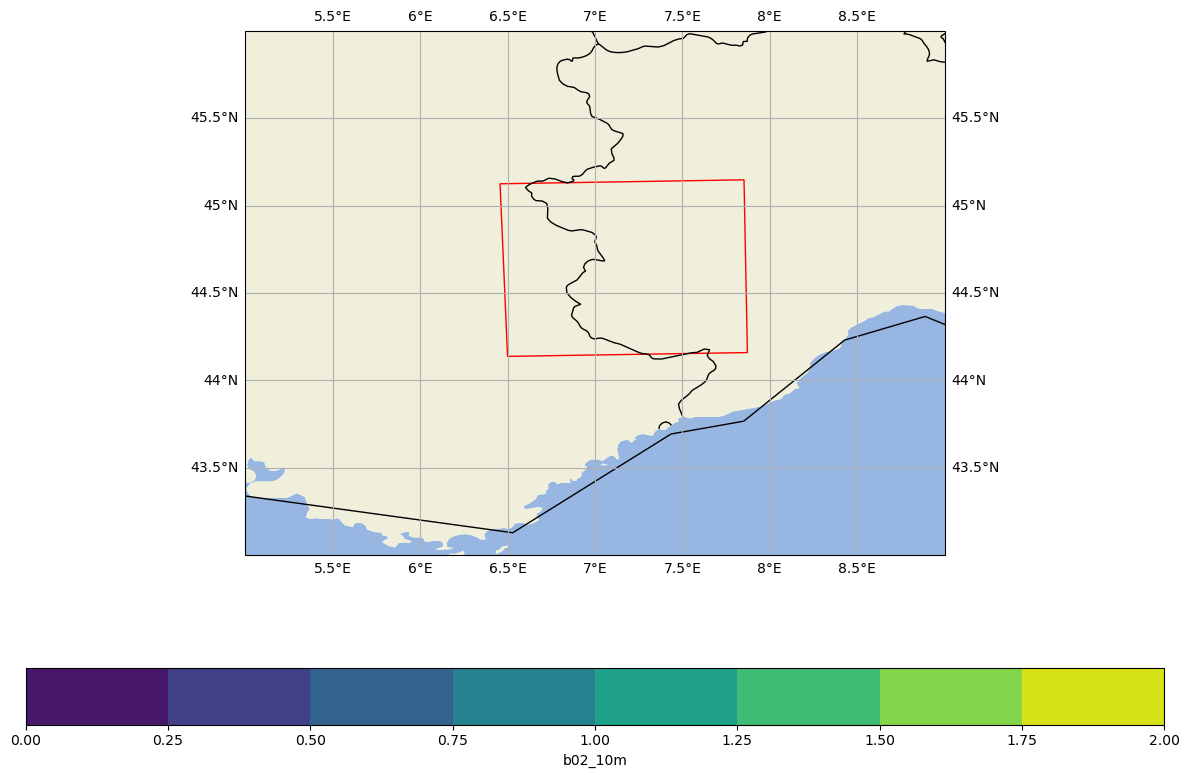

In [17]:
_, ax = plt.subplots(subplot_kw={"projection": DESIRED_PROJECTION}, figsize=FIGSIZE)

# Plot cartopy geographic information
ax.coastlines(resolution=RESOLUTION_CARTOPY)
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.OCEAN)
ax.add_feature(cf.LAND)
gl = ax.gridlines(draw_labels=True, crs=DESIRED_PROJECTION)


b02 = dt["measurements/reflectance/r10m"]["b02"]
plt.contourf(b02[::SKIP_EVERY, ::SKIP_EVERY], transform=L1C_PROJECTION)
poly = mpatches.Polygon(
    geometry_from_product,
    closed=True,
    ec=POLYGON_COLOR,
    fill=False,
    lw=POLYGON_THICKNESS,
    transform=DESIRED_PROJECTION,
)
ax.add_patch(poly)
ax.set_extent(GEOGRAPHICAL_LIMITS, crs=DESIRED_PROJECTION)
cbar = plt.colorbar(orientation="horizontal")
cbar.set_label("b02_10m")
plt.tight_layout()

## Compute radiances

From: https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/product-types/level-1c

$\text{radiance} = \text{reflectance} \times \cos\left(\text{radians}(\text{SunZenithAngle})\right) \times \text{solarIrradiance} \times \frac{U}{\pi}$
$
\]


In [18]:
U: float = dt.attrs["other_metadata"][
    "reflectance_correction_factor_from_the_Sun-Earth_distance_variation_computed_using_the_acquisition_date"
]
U

1.03411047670495

In [19]:
# Be carefull, Sun Zenith Angle is expressed on the angles grid (5km), it needs to be reprojected on the 10m grid for computing radiances
# cosinus is applied now because we can not interpolate angles using a linear interpolation (discontinuity at 0°)
# On the other hand, cosines can be interpolated
# cos_zsa_5km: EOVariable = np.cos(np.deg2rad(xdt[].conditions.geometry.sza))
# cos_zsa_5km

cos_sza_5km: EOVariable = np.cos(np.deg2rad(dt["conditions/geometry/sun_angles"])).sel(
    angle="zenith"
)
cos_sza_5km

<xarray.DataArray 'sun_angles' (y: 23, x: 23)> Size: 4kB
dask.array<getitem, shape=(23, 23), dtype=float64, chunksize=(23, 23), chunktype=numpy.ndarray>
Coordinates:
    angle    <U7 28B 'zenith'
  * x        (x) int64 184B 300000 305000 310000 315000 ... 400000 405000 410000
  * y        (y) int64 184B 5000040 4995040 4990040 ... 4900040 4895040 4890040
Attributes:
    _eopf_attrs:  {'coordinates': ['angle', 'y', 'x'], 'dimensions': ['angle'...

In [20]:
# We will convert reflectances from band BAND to radiances
BAND: int = 2

# Band - 1 because Python list index starts at 0
solarIrradiance: float = np.float64(
    dt.attrs["stac_discovery"]["properties"]["bands"][BAND - 1]["solar_illumination"]
)

In [21]:
reflectance_b02_10m: EOVariable = dt["measurements/reflectance/r10m"]["b02"]
reflectance_b02_10m

<xarray.DataArray 'b02' (y: 10980, x: 10980)> Size: 964MB
dask.array<open_dataset-b02, shape=(10980, 10980), dtype=float64, chunksize=(1830, 1830), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) int64 88kB 300005 300015 300025 300035 ... 409775 409785 409795
  * y        (y) int64 88kB 5000035 5000025 5000015 ... 4890265 4890255 4890245
Attributes:
    _eopf_attrs:     {'add_offset': -0.1, 'coordinates': ['x', 'y'], 'dimensi...
    dtype:           <u2
    fill_value:      0
    long_name:       TOA reflectance from MSI acquisition at spectral band b0...
    proj:bbox:       [300000.0, 4890240.0, 409800.0, 5000040.0]
    proj:epsg:       32632
    proj:shape:      [10980, 10980]
    proj:transform:  [10.0, 0.0, 300000.0, 0.0, -10.0, 5000040.0, 0.0, 0.0, 1.0]
    proj:wkt2:       PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WG...
    units:           digital_counts
    valid_max:       65535
    valid_min:       1

In [22]:
# Interpolate sza on the angles grid to the 10m grid
cos_sza_10m: xr.DataArray = cos_sza_5km.interp_like(reflectance_b02_10m)
cos_sza_10m.compute()

<xarray.DataArray 'sun_angles' (y: 10980, x: 10980)> Size: 964MB
array([[0.37259027, 0.37259063, 0.37259099, ..., 0.37644357, 0.37644392,
        0.37644427],
       [0.37259171, 0.37259206, 0.37259242, ..., 0.376445  , 0.37644535,
        0.3764457 ],
       [0.37259314, 0.37259349, 0.37259385, ..., 0.37644643, 0.37644678,
        0.37644712],
       ...,
       [0.38824467, 0.38824502, 0.38824538, ..., 0.39208391, 0.39208426,
        0.3920846 ],
       [0.38824609, 0.38824645, 0.3882468 , ..., 0.39208533, 0.39208568,
        0.39208602],
       [0.38824751, 0.38824787, 0.38824822, ..., 0.39208675, 0.3920871 ,
        0.39208744]])
Coordinates:
    angle    <U7 28B 'zenith'
  * x        (x) int64 88kB 300005 300015 300025 300035 ... 409775 409785 409795
  * y        (y) int64 88kB 5000035 5000025 5000015 ... 4890265 4890255 4890245
Attributes:
    _eopf_attrs:  {'coordinates': ['angle', 'y', 'x'], 'dimensions': ['angle'...

In [23]:
# For simplicity, radiance computation assume that reflectances equal numerical counts

radiance = reflectance_b02_10m * cos_sza_10m * solarIrradiance * U / np.pi
radiance

<xarray.DataArray (y: 10980, x: 10980)> Size: 964MB
dask.array<truediv, shape=(10980, 10980), dtype=float64, chunksize=(1830, 1830), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) int64 88kB 300005 300015 300025 300035 ... 409775 409785 409795
  * y        (y) int64 88kB 5000035 5000025 5000015 ... 4890265 4890255 4890245
    angle    <U7 28B 'zenith'

## Visualise

Visualize computational graph


In [24]:
radiance.data.visualize()

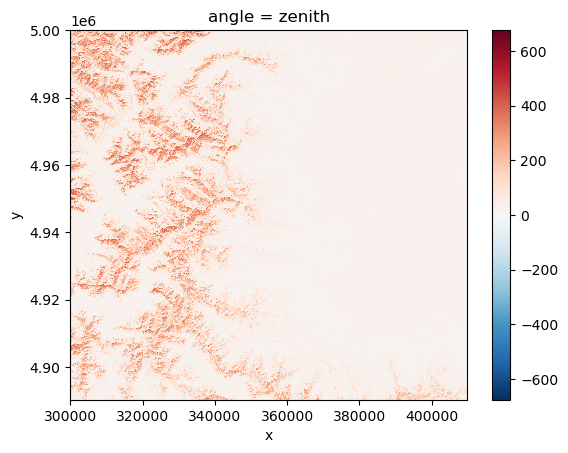

In [25]:
radiance.plot()

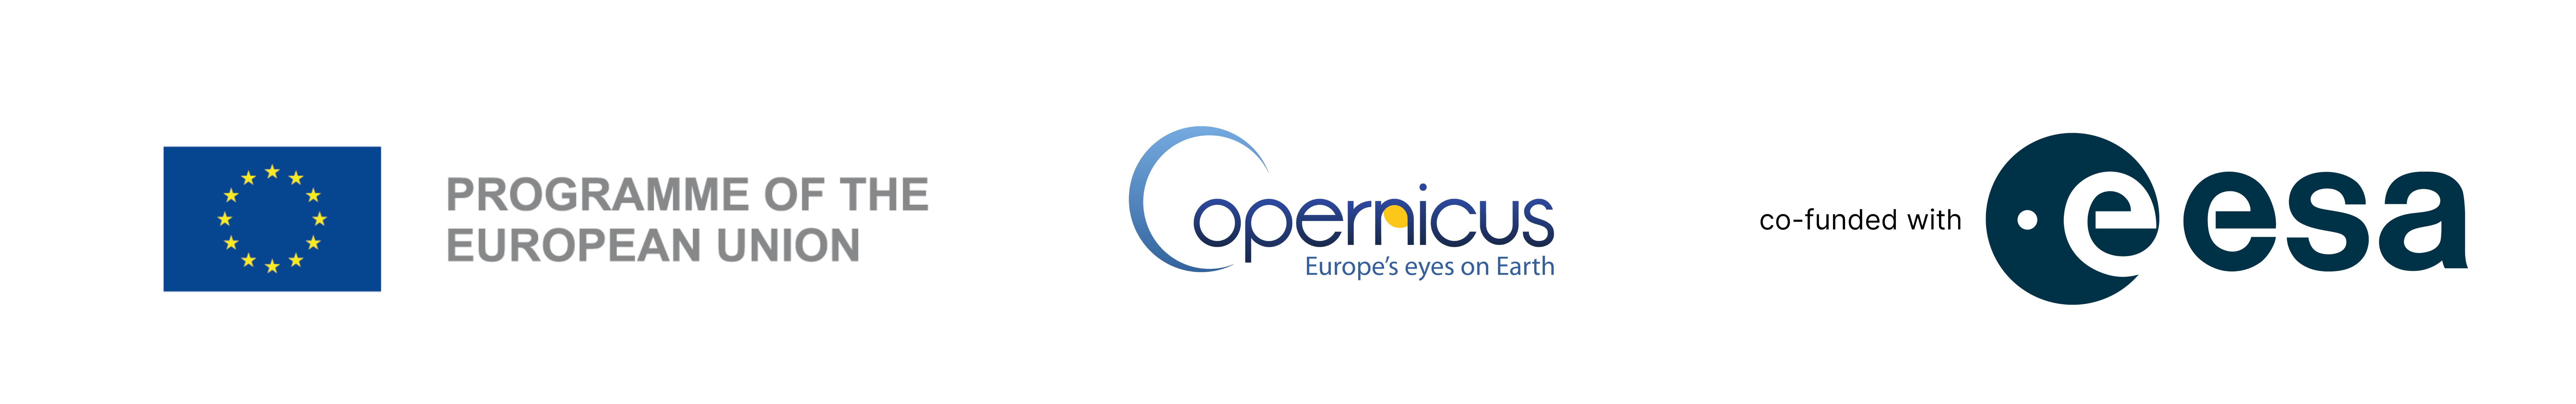